In [1]:
#!pip install openai
import requests
import openai
import numpy as np
import json
import random
import pandas as pd
import pickle
from pathlib import Path
from PIL import Image
from typing import List, Tuple
from io import BytesIO

import tensorflow as tf

In [18]:
labels = pd.read_csv("labels.csv")
labels["skin_tone"].unique()

array([nan, 'monk_1', 'monk_6', 'monk_3', 'monk_2', 'monk_8', 'monk_4',
       'monk_5', 'monk_9', 'monk_7', 'monk_10'], dtype=object)

In [9]:

def query_dalle(prompt, n=1):
  return openai.Image.create(
    prompt=prompt,
    n=n,
    size="256x256"
  )

def read_json(path) -> dict:
    with open(path) as f:
        return json.load(f)
      

config = read_json("openai_config.json")
openai.api_key = config["key"]



In [29]:
MONK = {
    "monk_1": "very pale",
    "monk_2": "pale",
    "monk_3": "light",
    "monk_4": "olive",
    "monk_5": "light brown",
    "monk_6": "brown",
    "monk_7": "dark brown",
    "monk_8": "dark",
    "monk_9": "black",
    "monk_10": "very black"
}

def create_prompt(age, gender, skin_tone) -> str: 
  age_min, age_max = age.split("_")
  new_age = random.randint(a=int(age_min), b=int(age_max))
  monk = MONK[skin_tone] 
  base_prompt =  "a close-up face photo of a XXX year old, YYY-skinned ZZZ, photo-realistic"
  return base_prompt.replace("XXX", str(new_age)).replace("YYY", monk).replace("ZZZ", gender)



In [33]:
import itertools

combis = list(itertools.product(labels["age"].dropna().unique(), ["male", "female"], MONK.keys()))
prompts = [create_prompt(age=age, gender=gender, skin_tone=skin_tone) for age, gender, skin_tone in combis]

In [47]:
from tqdm import tqdm
import time

responses = []
for prompt in tqdm(prompts):
  try:
    response = query_dalle(prompt)
    responses.append(response["data"])
  except openai.APIError:
    print("caught an error!")
    time.sleep(10)
    try:
      response = query_dalle(prompt)
      responses.append(response["data"])
    except openai.APIError as e:
      print("another one")
      raise e 
  time.sleep(5)
  
  
  


  8%|▊         | 6/80 [01:01<12:34, 10.20s/it]

caught an error!


100%|██████████| 80/80 [16:14<00:00, 12.18s/it]


In [52]:
urls = [response[0]["url"] for response in responses]

In [80]:
def read_img(path, img_size: Tuple[int, int]=(224,224)) -> Image.Image:
    return Image.open(path).convert("RGB").resize(img_size)

def read_img_url(url: str) -> Image.Image:
    response = requests.get(url)
    return read_img(BytesIO(response.content))



In [74]:
imgs = [read_img_url(url) for url in urls]

In [81]:
imgs = [img.resize((224, 224)) for img in imgs]

In [2]:
# download VGG-16 with fully connected layers
vgg = tf.keras.applications.vgg16.VGG16(
    include_top=True,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

# remove the classification layer
new_model = tf.keras.models.Sequential()
for layer in vgg.layers[:-1]:
    new_model.add(layer)




In [3]:
preprocess = tf.keras.applications.vgg16.preprocess_input


In [6]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#np.save("gdrive/MyDrive/data/dalle_imgs_preprocessed.npy", processed_imgs)
processed_imgs = np.load("gdrive/MyDrive/data/dalle_imgs_preprocessed.npy")

In [5]:
preds = new_model.predict(processed_imgs)

3/3 [==============================] - 12s 841ms/step


In [9]:
preds.shape

(79, 4096)

In [89]:
import pickle

with open("gdrive/MyDrive/data/dalle_imgs.pkl", "wb") as f:
  pickle.dump(imgs, f)

In [10]:
# Now lets try to load all the (test) imgs
!unzip -q gdrive/MyDrive/data_bb1_img_recognition.zip -d .

In [6]:
test_labels = pd.read_csv(next(Path("test").glob("*.csv")))
test_imgs = [tf.keras.utils.load_img(Path("test") / path, target_size=(224, 224)) for path in test_labels["name"]]
test_preprocessed = [preprocess(np.asarray(img)) for img in test_imgs]

In [8]:
test_preds = new_model.predict(np.array(test_preprocessed))

94/94 [==============================] - 15s 166ms/step


In [11]:
np.save("gdrive/MyDrive/data/vgg_test_preds.npy", test_preds)
np.save("gdrive/MyDrive/data/vgg_dalle_preds.npy", preds)


# Pedal to the metal

In [15]:
import pandas as pd
import numpy as np
import pickle

def read_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

dalle_preds = np.load("../train/vgg_dalle_preds.npy")
test_preds = np.load("../train/vgg_test_preds.npy")
test_labels = pd.read_csv("../test/labels.csv", index_col=0)
dalle_imgs = read_pickle("../train/dalle_imgs.pkl")

In [29]:
from scipy.spatial import KDTree

tree = KDTree(dalle_preds)
dist, ind = tree.query(test_preds, k=5)


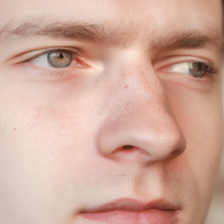

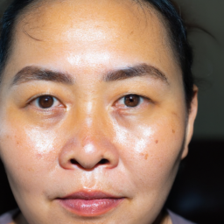

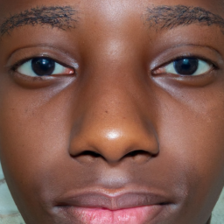

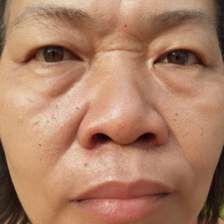

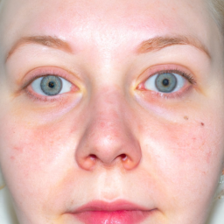

In [46]:
test_inds = ind[1475]
for idx in test_inds:
    display(dalle_imgs[idx])

In [45]:
black_test = test_labels[test_labels["skin_tone"] == "monk_10"].sample(1)
black_test

,name,skin_tone,gender,age,real_face
1475,TEST1475.png,monk_10,male,0_17,1.0


In [ ]:
test_